<a href="https://colab.research.google.com/github/mov-z/Vision-AI-Tutorials/blob/main/SAM_Automatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SAM Automatic Mask Generation**

이 예제에서는 **Segment Anything Model (SAM)**을 사용하여 **이미지를 자동으로 분할**하는 방법을 보여줍니다. 사용자는 이미지를 업로드하고, SAM 모델을 통해 **마스크를 생성**합니다.


## **1. 환경 세팅**
- 필요 패키지 설치
- 라이브러리 및 모듈 임포트
- 필요 함수 선언

In [ ]:
import torch
import torchvision
import sys

# PyTorch, Torchvision 버전 및 CUDA 사용 가능 여부 출력
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

# 표준 출력 차단 (설치 및 다운로드 명령어에만 적용)
import os
import contextlib

with open(os.devnull, "w") as fnull:
    with contextlib.redirect_stdout(fnull):
        !{sys.executable} -m pip install opencv-python matplotlib > /dev/null 2>&1
        !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git' > /dev/null 2>&1

        !mkdir -p images
        !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg > /dev/null 2>&1
        !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth > /dev/null 2>&1


PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import io
from PIL import Image
from google.colab import files

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


def resize_image(image: np.ndarray, target_size: int = 1000) -> np.ndarray:
    # 이미지의 현재 크기
    height, width = image.shape[:2]

    # 가로 세로 중 큰 쪽의 비율을 계산
    if height > width:
        scale = target_size / height
    else:
        scale = target_size / width

    # 새로운 크기 계산
    new_width = int(width * scale)
    new_height = int(height * scale)

    # 이미지 리사이징
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return resized_image

## **2. 이미지 업로드 및 시각화**
- 사용자가 이미지를 업로드하면, 해당 이미지를 로드하고 시각화
- 다운로드한 샘플 이미지를 사용하려면 주석 처리된 코드를 사용할 수 있음

In [ ]:
# 이미지를 업로드해서 사용하는 경우
image_file = files.upload()
image = io.BytesIO(image_file[list(image_file.keys())[0]])
image = np.array(Image.open(image))
image = resize_image(image)

# 다운받은 샘플 이미지를 사용하는 경우
# image = cv2.imread('images/dog.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = resize_image(image)

Saving pexels-pixabay-416405.jpg to pexels-pixabay-416405 (1).jpg


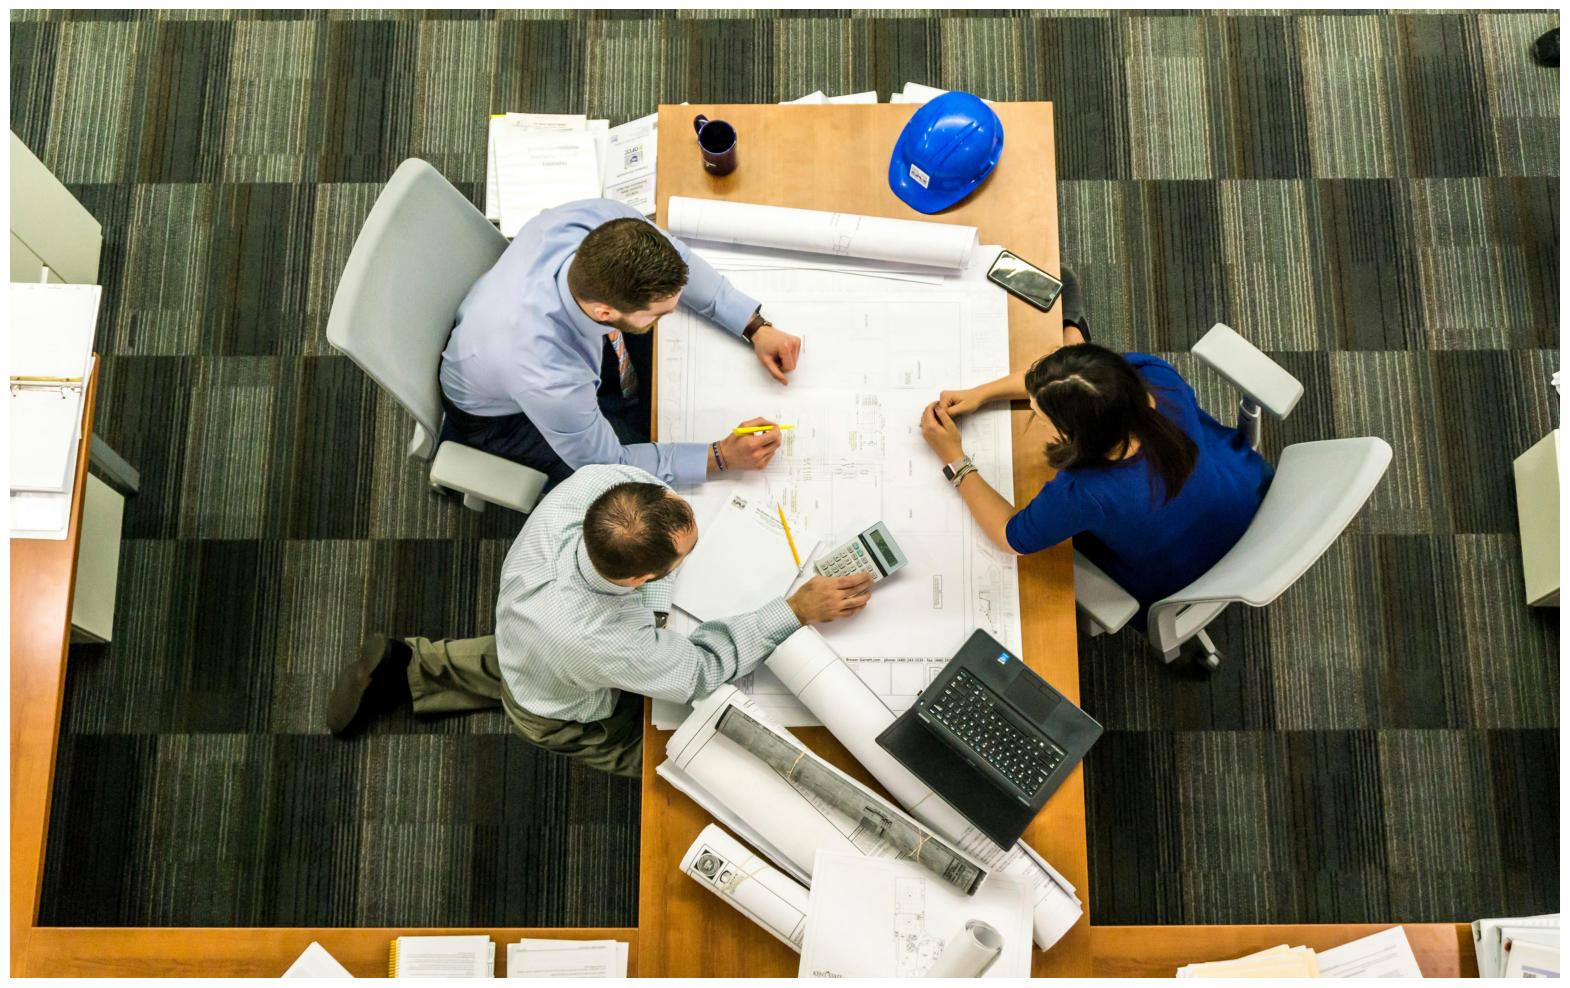

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## **3. SAM 모델 초기화 및 마스크 생성**
- SAM 모델을 초기화하고 CUDA 디바이스로 이동



In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## **4. Default 마스크 생성**
- `SamAutomaticMaskGenerator`를 사용하여 입력 이미지에서 자동으로 마스크를 생성
- `generate` default parameter 사용


In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [ ]:
print(len(masks))
print(masks[0].keys())

139
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


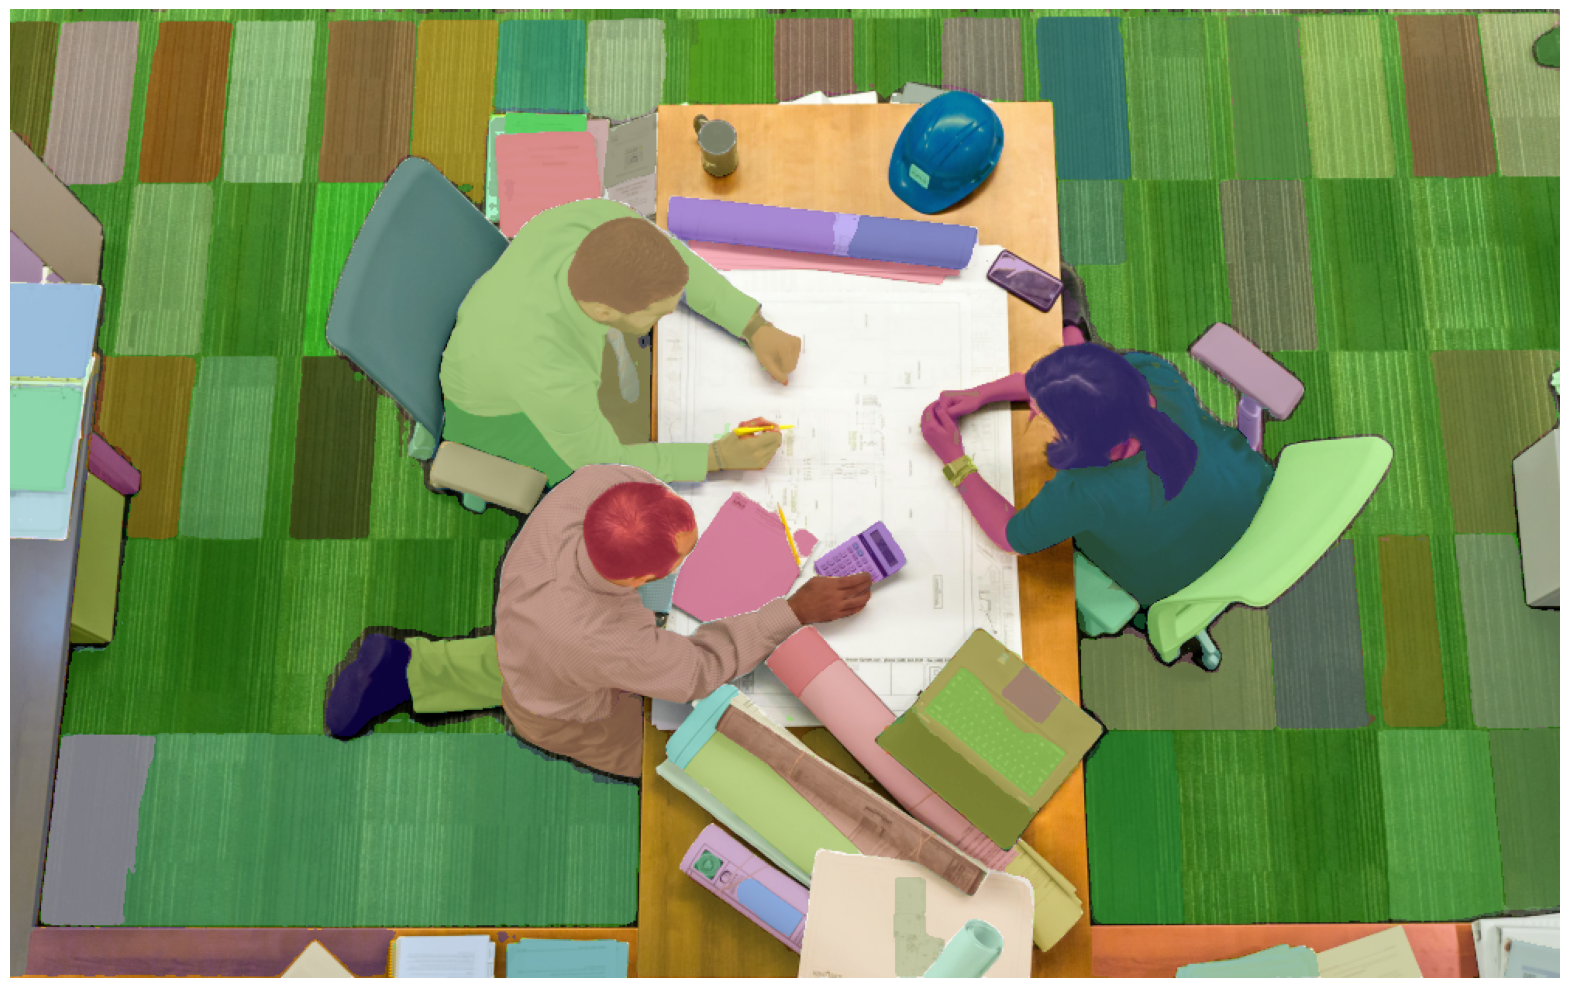

In [ ]:
# 마스크 시각화 - 각 마스크는 랜덤 색상으로 표시
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## **5. `generate` parameter 설정**

마스크 생성기를 설정하여 새로운 파라미터로 마스크를 생성합니다. 다양한 설정을 통해 더 정교한 마스크를 생성할 수 있습니다.

- `model`
  - 사용하려는 SAM 모델을 지정
  - 이 경우 sam 변수에 저장된 모델 인스턴스를 사용

- `points_per_side`
  - 각 마스크를 생성하는 데 사용되는 포인트의 수를 설정
  - 값이 클수록 더 많은 포인트가 생성되어 세밀한 마스크를 만들 수 있음
  - 예를 들어, 32는 마스크 주위의 포인트를 32개 배치하는 것을 의미

- `pred_iou_thresh`
  - 예측된 마스크의 IoU (Intersection over Union) 임계값
  - 이 값 이상인 마스크만 선택됨

- `stability_score_thresh`
  - 마스크의 안정성 점수 임계값
  - 이 값 이상인 마스크만 생성됨
  - 안정성 점수는 예측된 마스크의 일관성을 나타내며, 이 값을 조정하여 더 안정적인 마스크를 선택할 수 있음

- `crop_n_layers`
  - 이미지에서 마스크를 생성하기 위해 사용할 크롭 레이어의 수
  - 이 값을 높이면 여러 레이어에서 마스크를 생성하여 더 정교한 결과를 얻을 수 있음

- `crop_n_points_downscale_factor`
  - 크롭된 이미지에서 사용할 포인트 수의 다운스케일링 인자
  -  값이 클수록 더 적은 수의 포인트를 사용하여 처리 속도가 빨라질 수 있지만, 세밀함이 줄어들 수 있음

- `min_mask_region_area`
  - 생성된 마스크의 최소 면적
  - 이 값 이하의 마스크는 필터링됨


In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

195

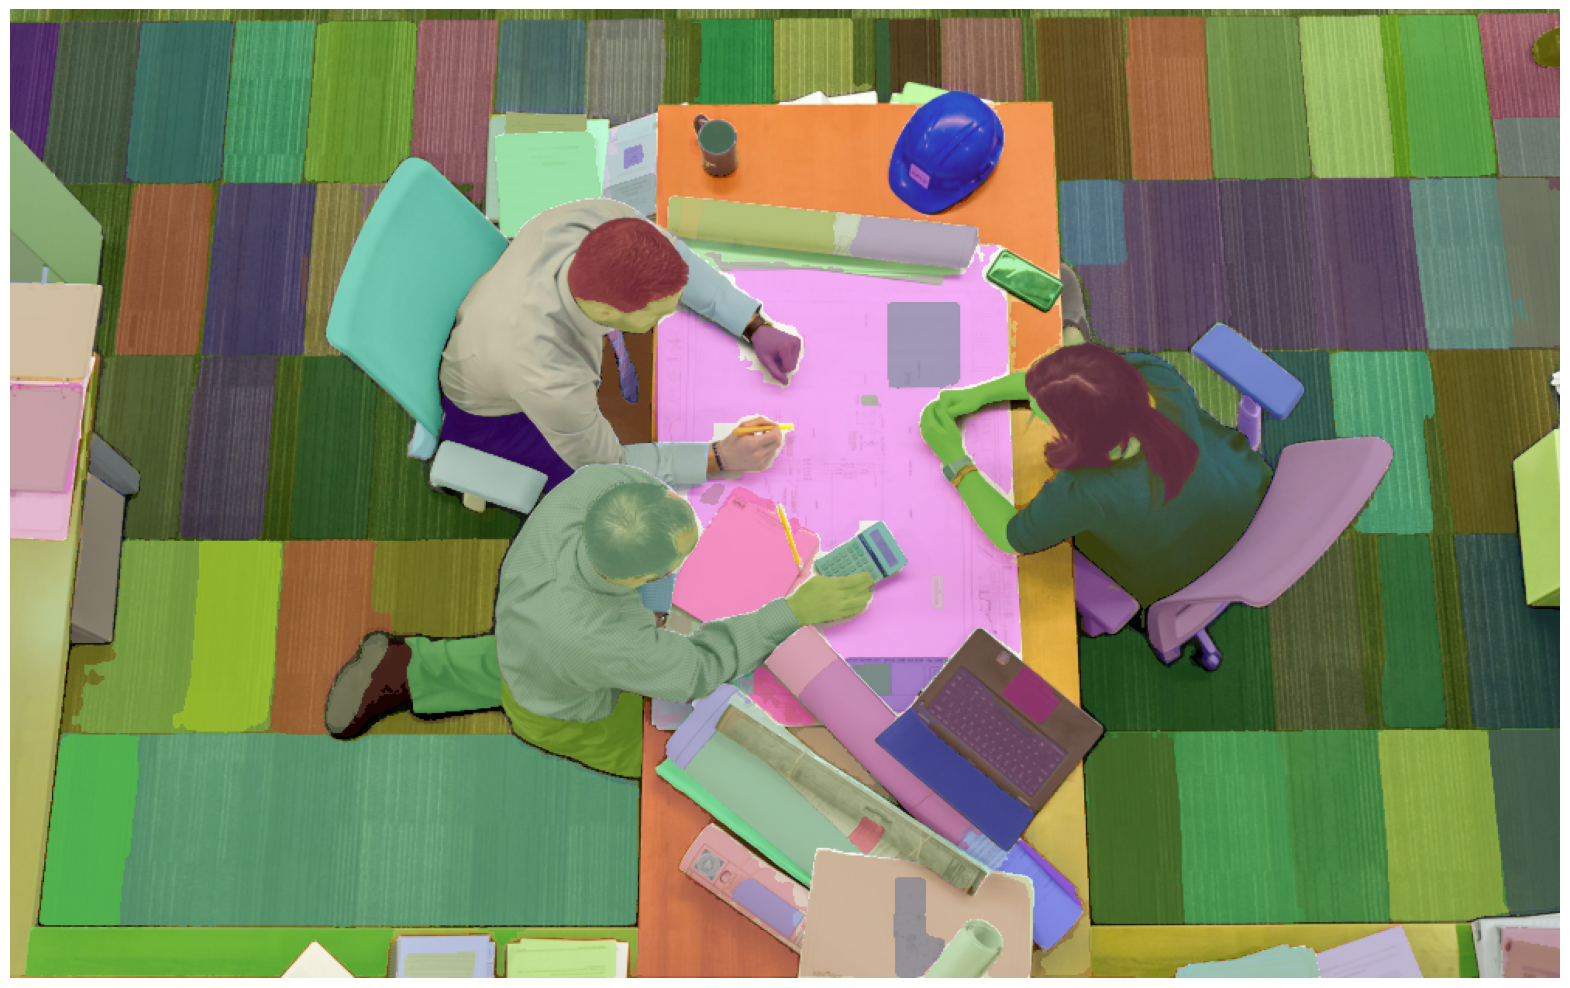

In [ ]:
# 마스크 시각화 - 각 마스크는 랜덤 색상으로 표시
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()